# RNN Model Development

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta


## Google Colab <-> Drive Mouting

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Datasets : Dogecoin + Samoyedcoin

### Importing Dogecoin data (hrly)

In [3]:
now = datetime.now()

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [4]:
path = "/content/gdrive/MyDrive/Colab Notebooks/data_garrit/"

In [5]:
df = pd.read_csv(path + 'dogecoin_history_1h_2021-08-28T00_00_00Z---2021-11-26T00_00_00Z.csv')
df.rename(columns= {"Unnamed: 0": "Date"}, inplace= True)
df["datetime"] = pd.to_datetime(df["datetime"], infer_datetime_format= True)
df["datetime"] = df.datetime.apply(lambda x: hour_rounder(x))
df = df.set_index("datetime")
df.interpolate(method= "linear", inplace= True)
df.head()

,timestamp,price,market_caps,total_volumes
datetime,,,,
2021-08-28 00:00:00,1630108814398,0.249013,3.268233e+10,1.686712e+09
2021-08-28 01:00:00,1630112407995,0.253279,3.315049e+10,1.703308e+09
2021-08-28 02:00:00,1630116016592,0.250394,3.279208e+10,1.677961e+09
2021-08-28 03:00:00,1630119638422,0.248032,3.258069e+10,1.700922e+09
2021-08-28 04:00:00,1630123200414,0.247505,3.244109e+10,1.657184e+09


In [6]:
df.shape

(2163, 4)

In [7]:
df.drop_duplicates().shape

(2163, 4)

In [8]:
# here comes the import of the second coin

In [9]:
df2 = pd.read_csv(path + 'gt_doge_samo_0410-2611')

df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["dogecoin"]]
df2.head()

,dogecoin
date,
2021-10-04 18:00:00,51
2021-10-04 19:00:00,56
2021-10-04 20:00:00,100
2021-10-04 21:00:00,80
2021-10-04 22:00:00,65


In [10]:
df2.shape

(1293, 1)

In [11]:
df_final_doge = df[["price"]].join(df2, how= "outer")
df_final_doge.drop(df_final_doge[df_final_doge.price.isnull()].index, inplace= True)
df_final_doge.fillna(-1, inplace= True)

In [12]:
df_final_doge.rename(columns={"dogecoin": "Google_Trends"}, inplace= True)

In [13]:
df_final_doge.shape

(2187, 2)

In [14]:
df_final_doge

,price,Google_Trends
2021-08-28 00:00:00,0.249013,-1.0
2021-08-28 01:00:00,0.253279,-1.0
2021-08-28 02:00:00,0.250394,-1.0
2021-08-28 03:00:00,0.248032,-1.0
2021-08-28 04:00:00,0.247505,-1.0
...,...,...
2021-11-25 19:00:00,0.200995,85.0
2021-11-25 20:00:00,0.199534,87.0
2021-11-25 21:00:00,0.200215,92.0
2021-11-25 22:00:00,0.198196,94.0


### Importing Samoyedcoin data

In [15]:
df_s = pd.read_csv(path + 'samoyedcoin_history_1h_2021-08-28T00_00_00Z---2021-11-26T00_00_00Z.csv')
df_s["datetime"] = pd.to_datetime(df_s["datetime"], infer_datetime_format= True)
df_s["datetime"] = df_s.datetime.apply(lambda x: hour_rounder(x))
df_s = df_s.set_index("datetime")
df_s.interpolate(method= "linear", inplace= True)
#df_s.rename(columns= {"price": "samoyedcoin"})
df_s = df_s[["price"]]
df_s.head()


,price
datetime,
2021-08-28 00:00:00,0.004132
2021-08-28 01:00:00,0.004122
2021-08-28 02:00:00,0.004105
2021-08-28 03:00:00,0.004155
2021-08-28 04:00:00,0.004198


In [16]:
df2 = pd.read_csv(path + 'gt_doge_samo_0410-2611')
df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["samoyedcoin"]]
df2.head()

,samoyedcoin
date,
2021-10-04 18:00:00,0
2021-10-04 19:00:00,0
2021-10-04 20:00:00,0
2021-10-04 21:00:00,0
2021-10-04 22:00:00,0


In [17]:
df_final_samo = df_s[["price"]].join(df2, how= "outer")
df_final_samo.drop(df_final_samo[df_final_samo.price.isnull()].index, inplace= True)
df_final_samo.fillna(-1, inplace= True)

In [18]:
df_final_samo.shape

(2188, 2)

In [19]:
df_final_samo

,price,samoyedcoin
2021-08-28 00:00:00,0.004132,-1.0
2021-08-28 01:00:00,0.004122,-1.0
2021-08-28 02:00:00,0.004105,-1.0
2021-08-28 03:00:00,0.004155,-1.0
2021-08-28 04:00:00,0.004198,-1.0
...,...,...
2021-11-25 19:00:00,0.074394,68.0
2021-11-25 20:00:00,0.073352,45.0
2021-11-25 21:00:00,0.073492,97.0
2021-11-25 22:00:00,0.073442,0.0


### Log-transformation

In [20]:
df_final_doge["price"] = np.log(df_final_doge["price"])
df_final_samo["price"] = np.log(df_final_samo["price"])

## Reshaping Data

### **Get X and y** : `DRAFT FOR ONE CRYPTO`

In [26]:
# Davy : drafting the code
dataset_doge = df_final_doge.values
dataset_doge.shape

(2187, 2)

In [27]:
# Window size = 48 hours
window_size = 48

In [28]:
# how many points in the future ? 
future_horizon = 24 #predicting the next 24 hours

In [29]:
# last possible start when sliding the window
last_possible_start = dataset_doge.shape[0] - window_size - future_horizon
last_possible_start

2115

In [30]:
X = []
y = []

for i in range(0, last_possible_start):
  X.append(dataset_doge[i: i + window_size, :])
  y.append(dataset_doge[i + window_size: i + window_size + future_horizon,0])

In [31]:
X = np.array(X)
X.shape

(2115, 48, 2)

In [32]:
y = np.array(y) # predicting the next five days
y.shape

(2115, 24)

### **Get X and y** : `FUNCTION`

In [135]:
window_size = 48
future_horizon = 6

def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size, :])
    y.append(dataset[i + window_size: i + window_size + future_horizon,0])

  return np.array(X), np.array(y)

In [136]:
X_example_doge, y_example_doge = get_X_y(window_size, future_horizon, dataset_doge)

In [137]:
X_example_doge.shape

(2133, 48, 2)

In [138]:
y_example_doge.shape

(2133, 6)

### **Get X and y** : `DRAFT FOR TWO CRYPTOS`

In [139]:
dataset_samo = df_final_samo.values
dataset_samo_v2 = dataset_samo[:-1,:]
dataset_samo_v2.shape

(2187, 2)

In [140]:
dataset_doge.shape

(2187, 2)

In [141]:
split_doge = int(df_final_doge.shape[0]*0.8)
split_samo = int(dataset_samo_v2.shape[0]*0.8)

train_size = split_doge
train_size


1749

In [142]:
test_size = dataset_doge.shape[0] - train_size
test_size

438

In [143]:
train_doge, test_doge = dataset_doge[:split_doge], dataset_doge[split_doge:]
train_samo, test_samo = dataset_samo_v2[:split_samo], dataset_samo_v2[split_samo:]

In [144]:
train_doge.shape

(1749, 2)

In [145]:
test_doge.shape

(438, 2)

In [146]:
train_samo.shape

(1749, 2)

In [147]:
test_samo.shape

(438, 2)

In [148]:
scaler_doge = MinMaxScaler()

scaler_doge.fit(train_doge)
train_doge_scaled = scaler_doge.transform(train_doge)
test_doge_scaled = scaler_doge.transform(test_doge)

In [149]:
scaler_samo = MinMaxScaler()

scaler_samo.fit(train_samo)
train_samo_scaled = scaler_samo.transform(train_samo)
test_samo_scaled = scaler_samo.transform(test_samo)

In [150]:
window_size

48

In [151]:
future_horizon

6

In [152]:
# get_X_y for doge & samo datasets TRAIN
X_train_doge, y_train_doge = get_X_y(window_size, future_horizon, train_doge_scaled)
X_train_samo, y_train_samo = get_X_y(window_size, future_horizon, train_samo_scaled)

In [153]:
# get_X_y for doge & samo datasets TEST
X_test_doge, y_test_doge = get_X_y(window_size, future_horizon, test_doge_scaled)
X_test_samo, y_test_samo = get_X_y(window_size, future_horizon, test_samo_scaled)

In [154]:
X_train_doge.shape, y_train_doge.shape

((1695, 48, 2), (1695, 6))

In [155]:
X_train_samo.shape, y_train_samo.shape

((1695, 48, 2), (1695, 6))

**Concatenating the features of different cryptos and their targets**

In [78]:
# desired shape 
# 2115 time series
# 48 days of observations
# 2 cryptoes x 2 features = 4 features

In [157]:
two_cryptos_X_train = np.stack([X_train_doge,X_train_samo], axis = 2).reshape(len(X_train_doge),window_size,-1)
two_cryptos_X_train.shape

(1695, 48, 4)

In [158]:
two_cryptos_y_train = np.stack([y_train_doge,y_train_samo], axis = 2).reshape(len(y_train_doge),future_horizon,-1)
two_cryptos_y_train.shape

(1695, 6, 2)

In [159]:
two_cryptos_y_train_reshaped = two_cryptos_y_train.reshape(len(two_cryptos_y_train),-1)
two_cryptos_y_train_reshaped.shape

(1695, 12)

In [114]:
# might need to pad, but let's try to fit a model with that first

In [160]:
two_cryptos_X_test = np.stack([X_test_doge,X_test_samo], axis = 2).reshape(len(X_test_doge),window_size,-1)
two_cryptos_X_test.shape

(384, 48, 4)

In [161]:
two_cryptos_y_test = np.stack([y_test_doge,y_test_samo], axis = 2).reshape(len(y_test_doge),future_horizon,-1)
two_cryptos_y_test.shape

(384, 6, 2)

In [162]:
two_cryptos_y_test_reshaped = two_cryptos_y_test.reshape(len(two_cryptos_y_test),-1)
two_cryptos_y_test_reshaped.shape

(384, 12)

### **Get X and y** : `FUNCTION FOR TWO CRYPTOS`

❗️ WORK IN PROGRESS ❗️

**reshape_data** : taking the horizon into consideration

In [111]:
## creating train_test_split and scaling values



def reshape_data(df_final_doge, df_final_samo, history_size, horizon):

  dataset_doge = df_final_doge.values
  dataset_samo = df_final_samo.values

  #train_test_split
  
  split_doge = int(df_final_doge.shape[0]*0.8)
  split_samo = int(df_final_samo.shape[0]*0.8)

  train_doge, test_doge = dataset_doge[:split_doge], dataset_doge[split_doge:]
  train_samo, test_samo = dataset_samo[:split_samo], dataset_samo[split_samo:]

  # scaling the data
  scaler_doge = MinMaxScaler()

  scaler_doge.fit(train_doge)
  train_doge = scaler_doge.transform(train_doge)
  test_doge = scaler_doge.transform(test_doge)

  scaler_samo = MinMaxScaler()

  scaler_samo.fit(train_samo)
  train_samo = scaler_samo.transform(train_samo)
  test_samo = scaler_samo.transform(test_samo)

  # get_X_y for doge & samo datasets
  X_train_doge, y_train_doge = get_X_y(history_size, horizon, train_doge)
  X_train_samo, y_train_samo = get_X_y(history_size, horizon, train_samo)

  X_test_doge, y_test_doge = get_X_y(history_size, horizon, test_doge)
  X_test_samo, y_test_samo = get_X_y(history_size, horizon, test_samo)

  # creating multi-coin model with multiple features
  X_train_multi = [X_train_doge, X_train_samo]
  X_train_multi = np.array(X_train_multi, dtype='object')

  X_test_multi = [X_test_doge, X_test_samo]
  X_test_multi = np.array(X_test_multi, dtype='object')

  y_train_multi = [y_train_doge, y_train_samo]
  y_train_multi = np.array(y_train_multi, dtype='object')

  y_test_multi = [y_test_doge, y_test_samo] # order important for inverse transform
  y_test_multi = np.array(y_test_multi, dtype='object')

  # padding the data
  ## padding= post ???
  X_pad_train = pad_sequences(X_train_multi, dtype='float32', value=-1)
  X_pad_train = np.asarray(X_pad_train).astype('float32')

  X_pad_test = pad_sequences(X_test_multi, dtype='float32', value=-1)
  X_pad_test = np.asarray(X_pad_test).astype('float32')

  y_pad_train = pad_sequences(y_train_multi, dtype='float32', value=-1)
  y_pad_train = np.asarray(y_pad_train).astype('float32')

  y_pad_test = pad_sequences(y_test_multi, dtype='float32', value=-1)
  y_pad_test = np.asarray(y_pad_test).astype('float32')

  return X_pad_train, X_pad_test, y_pad_train, y_pad_test, scaler_doge, scaler_samo
  

In [112]:
X_pad_train, X_pad_test, y_pad_train, y_pad_test, scaler_doge, scaler_samo = reshape_data(df_final_doge, df_final_samo, horizon = 5, history_size=14)

In [45]:
X_pad_train.shape

(2, 2168, 14, 2)

In [53]:
y_pad_train.shape

(2, 2168, 5, 2)

In [47]:
X_pad_train[0][0], y_pad_train[0][0]

(array([[-1.3902503, -1.       ],
        [-1.3732641, -1.       ],
        [-1.384719 , -1.       ],
        [-1.3941964, -1.       ],
        [-1.3963227, -1.       ],
        [-1.3931859, -1.       ],
        [-1.400903 , -1.       ],
        [-1.4024998, -1.       ],
        [-1.4089702, -1.       ],
        [-1.4068834, -1.       ],
        [-1.4023124, -1.       ],
        [-1.4074941, -1.       ],
        [-1.4144078, -1.       ],
        [-1.4057324, -1.       ]], dtype=float32),
 array([[-1.4113902, -1.       ],
        [-1.4226389, -1.       ],
        [-1.4187297, -1.       ],
        [-1.4131716, -1.       ],
        [-1.4158534, -1.       ]], dtype=float32))

In [54]:
X_pad_train_reshaped = X_pad_train.reshape(2,2168,14*2)

In [56]:
y_pad_train.shape

(2, 2168, 5, 2)

In [59]:
X_pad_test.shape

(2, 2168, 14, 2)

In [57]:
X_pad_test_reshaped = X_pad_test.reshape(2,2168,14*2)

In [60]:
y_pad_test.shape

(2, 2168, 5, 2)

## Modeling

In [65]:
# # instantiating a model
# model = Sequential()

# # first network layer
# model.add(Masking(mask_value=-1))
# model.add(LSTM(units = 50, activation= "tanh", return_sequences= True))
# model.add(Dropout(0.2))

# # network layer's 2 - 5
# model.add(LSTM(units= 50, activation= "tanh", return_sequences= True))
# model.add(Dropout(0.2))
# #model.add(LSTM(units = 20, return_sequences= True))
# #model.add(Dropout(0.2))
# #model.add(LSTM(units= 50, return_sequences= True))
# #model.add(Dropout(0.2))
# #model.add(LSTM(units= 50, return_sequences= True))
# #model.add(Dropout(0.2))
# model.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
# model.add(Dropout(0.2))

# # network output layer
# model.add(Dense(1, activation= "linear")) # should be 24 for 24h forecast

# model.compile(optimizer= "adam", loss= "mse")

In [163]:
number_of_cryptos = 2
print(number_of_cryptos)
number_of_cryptos*future_horizon

2


12

In [164]:
def garrit():    
    number_of_cryptos = 2
    # instantiating a model
    model = Sequential()

    # first network layer
    model.add(Masking(mask_value=-1))
    model.add(LSTM(units = 50, activation= "tanh", return_sequences= True))
    model.add(Dropout(0.2))

    # network layer's 2 - 5
    model.add(LSTM(units= 50, activation= "tanh", return_sequences= True))
    model.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # network output layer
    # predicting future_horizon = 24 hours
    # for two cryptos
    model.add(Dense(number_of_cryptos *future_horizon, activation= "linear")) # should be 24 for 24h forecast

    model.compile(optimizer= "adam", loss= "mse")

    return model

In [165]:
model = garrit()

**train_test_split**

In [166]:
train_size

1749

In [167]:
two_cryptos_X_train.shape

(1695, 48, 4)

In [168]:
two_cryptos_y_train_reshaped.shape

(1695, 12)

In [169]:
# es = EarlyStopping(patience = 3, restore_best_weights= True) 

history = model.fit(two_cryptos_X_train, 
          two_cryptos_y_train_reshaped,
          validation_split= 0.2,
          epochs = 1,
          batch_size= 32,
          #callbacks= [es],
          verbose= 1)

43/43 [==============================] - 25s 157ms/step - loss: 0.0665 - val_loss: 0.1833


In [173]:
predictions_6_hours = model.predict(two_cryptos_X_test)

In [171]:
two_cryptos_X_test.shape

(384, 48, 4)

In [175]:
final_predictions = predictions_6_hours.reshape(len(predictions_6_hours), future_horizon, -1)
final_predictions.shape

(384, 6, 2)

In [176]:
predictions_doge = final_predictions[:,:,0]
predictions_samo = final_predictions[:,:,1]

In [178]:
predictions_doge.shape

(384, 6)

# Inverse Transform

In [185]:
min_doge = scaler_doge.data_min_[0]
min_doge

-1.782132928647977

In [186]:
max_doge = scaler_doge.data_max_[0]
max_doge

-1.2563300619516968

In [184]:
predictions_doge.shape

(384, 6)

$$ mm_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}} $$

$$ x = mm_{scaled} * (x_{max} - x_{min}) + x_{min} $$

In [188]:
unscaled_predictions_doge = predictions_doge * (max_doge - min_doge) + min_doge
unscaled_predictions_doge

array([[-1.4932632, -1.66041  , -1.6463724, -1.6105703, -1.6121085,
        -1.4993455],
       [-1.4934375, -1.66047  , -1.646481 , -1.6105381, -1.6119863,
        -1.4994549],
       [-1.4936926, -1.6605839, -1.6465926, -1.6105589, -1.611933 ,
        -1.4996238],
       ...,
       [-1.5629548, -1.6765094, -1.6647174, -1.6121199, -1.6547048,
        -1.5389467],
       [-1.5632145, -1.6765622, -1.6647805, -1.6122015, -1.6544573,
        -1.5390629],
       [-1.563497 , -1.676772 , -1.664715 , -1.6124873, -1.6540864,
        -1.5393159]], dtype=float32)

In [189]:
exponentiated_doge = np.exp(unscaled_predictions_doge)
exponentiated_doge

array([[0.2246384 , 0.19006103, 0.19274783, 0.19977364, 0.1994666 ,
        0.22327626],
       [0.22459926, 0.19004962, 0.1927269 , 0.19978008, 0.19949096,
        0.22325185],
       [0.22454196, 0.190028  , 0.19270541, 0.19977592, 0.1995016 ,
        0.22321412],
       ...,
       [0.20951608, 0.18702567, 0.1892441 , 0.1994643 , 0.19114846,
        0.214607  ],
       [0.20946167, 0.1870158 , 0.18923219, 0.19944806, 0.19119579,
        0.2145821 ],
       [0.20940252, 0.18697657, 0.18924457, 0.19939104, 0.19126672,
        0.21452782]], dtype=float32)

In [ ]:
def inverse_transformer(y, scaler):
  '''takes a one-dimensional input array (y_test or y_hat) and inverse transforms it.'''
  y = np.c_[y, np.ones(len(y))]
  y = scaler.inverse_transform(y)
  y= y[:,0]
  return y

In [ ]:
real_stock_price_doge = inverse_transformer(y_pad_test[0],scaler_doge)
real_stock_price_samo = inverse_transformer(y_pad_test[1],scaler_samo)


predicted_stock_price = inverse_transformer(model.predict(X_pad_test), scaler_doge)

ValueError: ignored

In [ ]:
np.exp(real_stock_price_doge)

array([0.24197062, 0.24172319, 0.24043454, 0.24333331, 0.24150567,
       0.24033273, 0.24148357, 0.24361593, 0.24441122, 0.244376  ,
       0.24763014, 0.24690418, 0.24537234, 0.24808335, 0.24490902,
       0.24224358, 0.243218  , 0.24278063, 0.24182562, 0.23777433,
       0.23956081, 0.24064378, 0.23736386, 0.23709758, 0.23863447,
       0.23834137, 0.23750503, 0.23813729, 0.23847493, 0.23785059,
       0.23829816, 0.23647024, 0.23629104, 0.23648822, 0.23682728,
       0.23342749, 0.23451334, 0.23430756, 0.23564888, 0.23624131,
       0.2364944 , 0.2363959 , 0.23749521, 0.23648024, 0.23445497,
       0.24101471, 0.23759193, 0.23647772, 0.2361615 , 0.23534915,
       0.23352389, 0.23012467, 0.22613638, 0.21902978, 0.22292838,
       0.22261667, 0.22261667, 0.22261667, 0.22261667, 0.22448395,
       0.22476254, 0.22650018, 0.22817552, 0.22997623, 0.22738303,
       0.22870318, 0.23024204, 0.22808765, 0.22893845, 0.22808788,
       0.22725289, 0.22746049, 0.22716153, 0.23028719, 0.23193

# Inverse Log Transform

In [ ]:
real_stock_price_doge = np.exp(real_stock_price_doge)
real_stock_price_samo = np.exp(real_stock_price_samo)

#predicted_stock_price = np.exp(predicted_stock_price)

#predicted_stock_price.shape

# Evaluate

RMSE = 0.006987121585922938


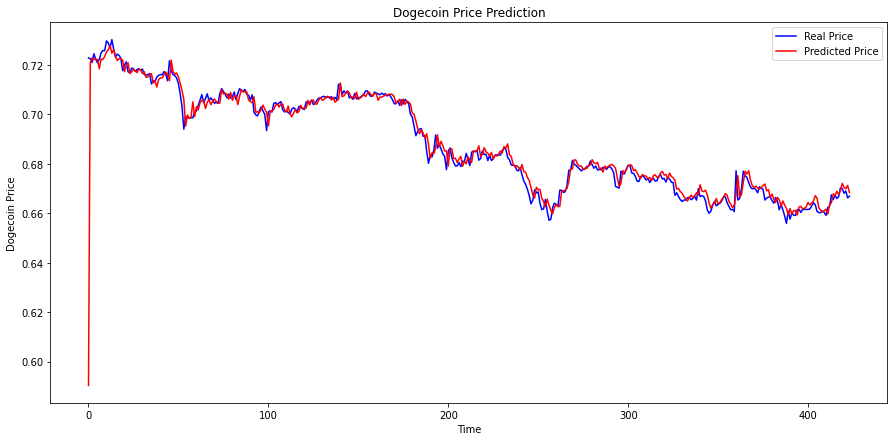

In [ ]:
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

print(f"RMSE = {rmse}")

plt.figure(figsize= (15,7))
plt.plot(real_stock_price, color = 'blue', label = "Real Price")
plt.plot(predicted_stock_price, color = 'red', label = "Predicted Price")
plt.title("Dogecoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Dogecoin Price")
plt.legend()

plt.show()

# Notes on different model performances

In [ ]:
eval_dict = {"optimizer": ["adam","adam","adam","adam","adam","adam","adam","adam","adam", "adam", "rmsprop", "rmsprop", "adam"],
             "loss": ["mse","mse","mse","mse","mse","mse","mse","mse","mse", "mse", "mse", "mse", "mse"],
              "history_size": [14, 14, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2],
             "epochs": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
             "layer0": [50,50,50,50,50,50, 50, 50, 50, 50, 50, 100, 100],
            "layer1": [10, 20, 20, 20, 50, 50, 0, 50, 20, 20, 50, 10, 10],
           "layer2": [10, 10, 10, 20, 10, 10, 0, 50, 0, 10, 10, 0, 0],
           "layer3": [0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer4": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer5": [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0],
            "output": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             "batch_size": [32,32,32,32,32,32,32,32,32,32,32,32,32],
           "rmse": [0.051, 0.037, 0.017, 0.018, 0.014, 0.021, 0.020, 0.023, np.NaN, 0.023, np.NaN, 0.020, 0.022]}

eval_df = pd.DataFrame.from_dict(eval_dict)

#for k,v in eval_dict.items():
  #print(f"{k} : {len(v)}")

eval_df

,optimizer,loss,history_size,epochs,layer0,layer1,layer2,layer3,layer4,layer5,output,batch_size,rmse
0,adam,mse,14,500,50,10,10,0,0,0,1,32,0.051
1,adam,mse,14,500,50,20,10,0,0,0,1,32,0.037
2,adam,mse,3,500,50,20,10,0,0,0,1,32,0.017
3,adam,mse,3,500,50,20,20,10,0,0,1,32,0.018
4,adam,mse,2,500,50,50,10,0,0,0,1,32,0.014
5,adam,mse,1,500,50,50,10,0,0,0,1,32,0.021
6,adam,mse,2,500,50,0,0,0,0,0,1,32,0.020
7,adam,mse,2,500,50,50,50,0,0,0,1,32,0.023
8,adam,mse,2,500,50,20,0,0,0,0,1,32,NaN
9,adam,mse,2,500,50,20,10,0,0,0,1,32,0.023


In [ ]:
df_final.head()

,price,Google_Trends
2021-08-28 00:00:00,-1.390250,-1.0
2021-08-28 01:00:00,-1.373264,-1.0
2021-08-28 02:00:00,-1.384719,-1.0
2021-08-28 03:00:00,-1.394196,-1.0
2021-08-28 04:00:00,-1.396323,-1.0


In [ ]:
df_pred = pd.DataFrame(X_test[0], columns= ["high", "Google_trends"])
df_pred

,high,Google_trends
0,0.623125,0.722772
1,0.640528,0.693069
2,0.651518,0.623762
3,0.647062,0.574257
4,0.648080,1.000000
5,0.750242,0.841584
6,0.772567,0.841584
7,0.733399,0.663366
8,0.718805,0.683168
9,0.714355,0.673267


In [ ]:
def preprocess(df, scaler):
    """method that pre-process the data"""

    # log transforming the data
    df["high"] = np.log(df["high"])

    # selecting relevant column from df
    dataset = df.values

    # scaling the data
    dataset_scaled = scaler.fit_transform(dataset)

    dataset_scaled = dataset_scaled.reshape(1,dataset.shape[0],dataset.shape[1])

    return dataset_scaled, scaler


def inverse_scaler(pred, scaler):

  pred = inverse_transformer(pred)

  pred = np.exp(pred)

  return pred

In [ ]:
df_pred_preproc, scaler = preprocess(df_pred, scaler)

In [ ]:
pred = model.predict(df_pred_preproc)
prediction = inverse_scaler(pred, scaler)[0][0]

prediction

IndexError: ignored

In [ ]:
df_pred_preproc.shape

In [ ]:
pred = model.predict(df_pred_preproc)[0][0]
pred

# Features

- historical price data
- google price data
- rendite (calculate daily return)
- kumulierte rendite (z.b. letzte 5 Tage)
- short term moving average (letzte 10 Tage)
- long term moving average (letzte 30 Tage)
- alternativ: binäres feature (liegt kurzfristiger MA über langfristigen MA)
- talib (financial indicators inkludieren)
- talib RSI (relative strength index)
- volumen inkludieren

- evtl. auf Klassifikationsproblem umsteigen